<a href="https://colab.research.google.com/github/YousefAlaaeldin/hand-written-digit-classifier/blob/main/DLtask_handdigitrecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing some of the needed libraries and functions


---



In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

downloads train data and splits to train and test data


---



In [ ]:
train_data = datasets.MNIST(  #sets parameter for picking train data
    root = 'data',
    train = True,
    transform= ToTensor(),
    download = True
)
test_data = datasets.MNIST(   #sets parameter for picking train data
    root = 'data',
    train =False,
    transform= ToTensor(),
    download = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 103037187.53it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22748487.10it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33143990.74it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17574288.53it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



show info about the data to make sure

---



In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_data.targets  #shows the digits that are supposed to be
                    #the correct target for each tensor transformed image

tensor([5, 0, 4,  ..., 5, 6, 8])

Make the dataloaders to allow inputing the data in batches

---





In [ ]:
Loaders = {
     'train' : DataLoader(train_data,batch_size=100,shuffle=True,num_workers=1),
     'test' : DataLoader(test_data,batch_size=100,shuffle=True,num_workers=1)
}

Define DL architechure and model

---



In [ ]:

class CNN(nn.Module):
    def __init__(self):
      super(CNN,self).__init__()

      self.conv1 = nn.Conv2d(1,10,kernel_size=5)#defines first layer with 1 (going to be image tensor) to 10 connected convolutionaly
      self.conv2 = nn.Conv2d(10,20,kernel_size=5) #defines another layer connected to first each 1 connected to 2 convolutionally
      self.conv2_drop = nn.Dropout2d()         #defines that the second layer will have node drop out
      self.fc1 = nn.Linear(320,50)             # defines the before the last layer connected linearly
      self.fc2 = nn.Linear(50,10)              # defines that last layer connected linearly

    def forward(self,x):            #defines the forwarding mechanism from start to last layer with each having its own activation function
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
      x = x.view(-1,320)
      x = F.relu(self.fc1(x))
      x = F.dropout(x, training=self.training)
      x = self.fc2(x)

      return F.softmax(x)


Define training and testing processes

---



In [ ]:
import torch

#define the device to work on , on GPU if the option is avalaiable cause it's faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#move the model  also the same device
model=CNN().to(device)

#define the optimization used
optimizer = optim.Adam(model.parameters(),lr=0.0015)

#define the loss function that will be used
loss_fn = nn.CrossEntropyLoss()

#define the training methodology
def train(epoch):
  model.train()      #put model in training mode
  for batch_idx,(data, target) in enumerate(Loaders['train']):  #loop over data in the batches
    data,target = data.to(device), target.to(device)            #make sure both data and target are on same device
    optimizer.zero_grad()
    output = model(data)      #get the supposed estimation of the model on the data
    loss = loss_fn(output,target)   #calculate loss using chosen loss function
    loss.backward()                 #backward propagate the loss
    optimizer.step()                # take a step of the chosen learning rate towards the optimum
    if batch_idx % 25 == 0:                                     #extra thing just to print as it processes how far its on and the loss and so
      print(f'train Epoch:{epoch} [{batch_idx * len(data)}/{len(Loaders["train"].dataset)} ({100.*batch_idx / len(Loaders["train"]):.0f}%)]\t{loss.item():.6f}')


#define the test methodology
def test():
  model.eval()  #puts model in test mode

  test_loss = 0     #initialize the loss and amount of correct to 0
  correct = 0

  with torch.no_grad():
    for data,target in Loaders['test']:       #loop over the samples from the test batch loader
      data,target = data.to(device),target.to(device)
      output = model(data)
      test_loss += loss_fn(output,target).item()
      pred = output.argmax(dim=1,keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(Loaders['test'].dataset)
  print(f'\n Test set : Average loss: {test_loss:.4f}, Accuracy {correct}/{len(Loaders["test"].dataset)} ({100.*correct / len(Loaders["test"].dataset):.0f}%\n)')


Start the actual training of the model
and track the accuracy and test set

---



In [ ]:
for epoch in range (1,11):  #loop and train 10 epoch and test after each epoch
  train(epoch)
  test()

<ipython-input-12-4e6c16025d4e>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


train Epoch:1 [0/60000 (0%)]	2.300255
train Epoch:1 [2500/60000 (4%)]	2.236735
train Epoch:1 [5000/60000 (8%)]	1.952381
train Epoch:1 [7500/60000 (12%)]	1.889873
train Epoch:1 [10000/60000 (17%)]	1.804284
train Epoch:1 [12500/60000 (21%)]	1.723781
train Epoch:1 [15000/60000 (25%)]	1.656133
train Epoch:1 [17500/60000 (29%)]	1.677721
train Epoch:1 [20000/60000 (33%)]	1.692346
train Epoch:1 [22500/60000 (38%)]	1.635952
train Epoch:1 [25000/60000 (42%)]	1.668103
train Epoch:1 [27500/60000 (46%)]	1.656957
train Epoch:1 [30000/60000 (50%)]	1.589320
train Epoch:1 [32500/60000 (54%)]	1.572518
train Epoch:1 [35000/60000 (58%)]	1.602110
train Epoch:1 [37500/60000 (62%)]	1.626725
train Epoch:1 [40000/60000 (67%)]	1.643706
train Epoch:1 [42500/60000 (71%)]	1.576327
train Epoch:1 [45000/60000 (75%)]	1.602623
train Epoch:1 [47500/60000 (79%)]	1.601004
train Epoch:1 [50000/60000 (83%)]	1.595660
train Epoch:1 [52500/60000 (88%)]	1.579942
train Epoch:1 [55000/60000 (92%)]	1.658153
train Epoch:1 [57500/

sadly i dont have GPU option :(

---



In [ ]:
device

device(type='cpu')

visualize some of the samples

prediction : 7


<ipython-input-12-4e6c16025d4e>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


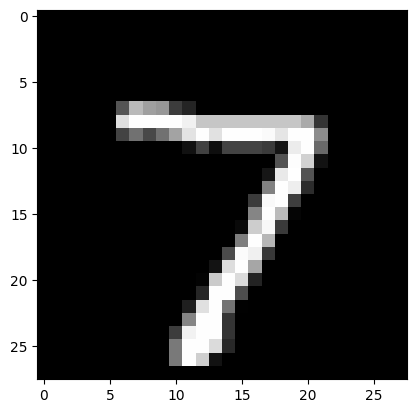

prediction : 2


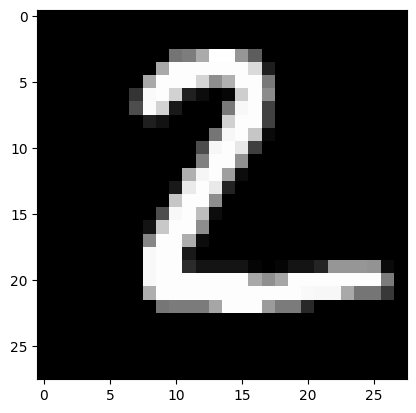

prediction : 1


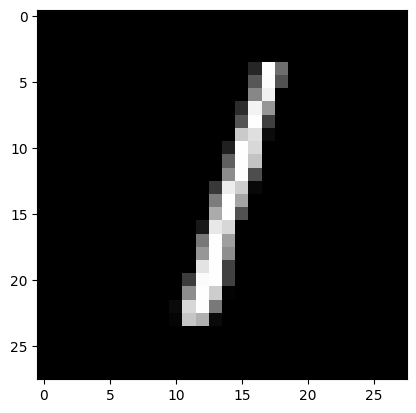

In [ ]:
import matplotlib.pyplot as plt

model.eval()

for sample_idx in range (0,3):
  data,target = test_data[sample_idx]
  data = data.unsqueeze(0).to(device)
  output =  model(data)
  prediction = output.argmax(dim = 1,keepdim=True).item()

  print(f'prediction : {prediction}')

  image =  data.squeeze(0).squeeze(0).cpu().numpy()

  plt.imshow(image,cmap='gray')
  plt.show()